# Imports

In [296]:
import pandas as pd
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# Neighborhoods from Wikipedia

In [3]:
# Wikipedia url
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [4]:
# Web scraping with Beautiful soup
response = requests.get(url=url)
response_text = response.text
soup = BeautifulSoup(response_text)
table = soup.find('table')
all_p = table.find_all('p')

In [5]:
# DataFrame creation
df = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhood'])

for p in all_p:
    text = p.getText().replace('\n', '')
    post_code = text[0:3]
    borough_neighborhood = text[3:].split("(")
    borough = borough_neighborhood[0]
    if borough != 'Not assigned':
        neighborhood = borough_neighborhood[1].replace(')', '').replace(' /', ',')
        if neighborhood == 'Not assigned':
            neighborhood = borough
        
        item_dict = {'PostalCode': post_code, 'Borough': borough, 'Neighborhood':neighborhood}
        df = df.append(item_dict, ignore_index=True)

In [6]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


# The latitude and the longitude

In [7]:
# import coordinates
geo_coord = pd.read_csv('Geospatial_Coordinates.csv') 

In [8]:
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
# to merge coordinates with toronto data
df_coord = pd.DataFrame(columns=['PostalCode', 'Latitude', 'Longitude'])
for i in range(df.shape[0]):
    for j in range(geo_coord.shape[0]):
        if df['PostalCode'][i] == geo_coord['Postal Code'][j]:
            item_append = {'PostalCode': df['PostalCode'][i], 'Latitude': geo_coord['Latitude'][j], 'Longitude': geo_coord['Longitude'][j]}
            df_coord = df_coord.append(item_append, ignore_index=True)

df = df.merge(df_coord, how='left', on='PostalCode')

In [10]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [11]:
df.shape

(103, 5)

# Data from Foursquare using API

In [12]:
CLIENT_ID = 'xxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxx' # your Foursquare Secret
ACCESS_TOKEN = 'xxxxxxxxx' # your FourSquare Access Token
VERSION = '20210720' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BYPLANM441GICCCLM0N43LFVIHPJG5JBP0DJ5N22WWP1KKI5
CLIENT_SECRET:Y3J1RPCAL2MC1AJJQSX0BSKL4U1UWEPZ105H5SHIYKHSY1BO


In [13]:
# Function for data from Foursquare
def getVenues(names, latitudes, longitudes, search_query, RADIUS=2000):
    
    toronto_venues = pd.DataFrame(columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])
    
    for name, lat, lng in zip(names, latitudes, longitudes):

        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            search_query,
        RADIUS)
            
        # make the GET request
        results = requests.get(url).json()["response"]
        
        # return only relevant information for each nearby venue
        for v in results['venues']:
            v_name = v['name']
            v_lat = v['location']['lat']
            v_lng = v['location']['lng']
            try:
                v_categories = v['categories'][0]['name']

            except IndexError:
                v_categories = 'No'
                
            item_dict = {'Neighborhood': name, 'Neighborhood Latitude': lat, 'Neighborhood Longitude': lng, 'Venue': v_name, 
                        'Venue Latitude': v_lat, 'Venue Longitude': v_lng, 'Venue Category': v_categories}
            
            
            toronto_venues = toronto_venues.append(item_dict, ignore_index=True)

            
    return(toronto_venues)

## Data for Toronto schools

In [14]:
toronto_schools = getVenues(names = df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], search_query = 'school')

In [15]:
toronto_schools.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Terraview-Willowfield Public School,43.764031,-79.310584,School
1,Parkwoods,43.753259,-79.329656,Metamorphosis Greek Orthodox School,43.746018,-79.354634,College Academic Building
2,Parkwoods,43.753259,-79.329656,Milne Valley Middle School,43.747156,-79.326374,Middle School
3,Parkwoods,43.753259,-79.329656,Cassandra Public School Pring Fling,43.748443,-79.328239,Elementary School
4,Parkwoods,43.753259,-79.329656,Cassandra Public School,43.748291,-79.328889,School


## Data for Toronto parks and playgrounds

In [16]:
toronto_parks = getVenues(names = df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], search_query = 'parks', RADIUS=3000)

In [17]:
toronto_parks.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Parks and Recreation Ontario,43.729016,-79.330077,No
1,Parkwoods,43.753259,-79.329656,Parkside Square,43.774223,-79.333600,Residential Building (Apartment / Condo)
2,Parkwoods,43.753259,-79.329656,Parkside Square Park,43.773882,-79.332189,Park
3,Parkwoods,43.753259,-79.329656,TTC Bus #24 Victoria Park Ave,43.735197,-79.306977,Bus Line
4,Parkwoods,43.753259,-79.329656,Victoria Park Square,43.776110,-79.324533,Road


In [18]:
toronto_playgrounds = getVenues(names = df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], search_query = 'Playground', RADIUS=3000)

In [19]:
toronto_playgrounds.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Forest Manor Playground,43.772803,-79.342687,Playground
1,Parkwoods,43.753259,-79.329656,Parkway Forest Park Playground,43.770099,-79.342039,Playground
2,Parkwoods,43.753259,-79.329656,Homestead Playground,43.774370,-79.343526,Playground
3,Parkwoods,43.753259,-79.329656,Denlow Public School Playground,43.745975,-79.363619,No
4,Victoria Village,43.725882,-79.315572,Extreme Fun Indoor Playground,43.720914,-79.312516,Playground


## Data for Toronto hospitals

In [20]:
toronto_hospitals  = getVenues(names = df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], search_query = 'hospital', RADIUS=2000)

In [21]:
toronto_hospitals.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,S.Michael 'S Hospital 30 Bond Street Toronto,43.767689,-79.338722,Hospital
1,Parkwoods,43.753259,-79.329656,Humber River Regional Hospital Church,43.767211,-79.349641,Hospital
2,Parkwoods,43.753259,-79.329656,Toronto Animal Health Partners Emergency And S...,43.745160,-79.353455,Veterinarian
3,Parkwoods,43.753259,-79.329656,Dana Hospitality,43.752744,-79.347571,Cafeteria
4,Victoria Village,43.725882,-79.315572,McLean Animal Hospital,43.732282,-79.305861,Pet Service


## Data for Toronto grocery stores

In [22]:
toronto_groceries = getVenues(names = df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'], search_query = 'Grocery Store', RADIUS=2000)

In [23]:
toronto_groceries.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,the REALTOR® Store @ TREB,43.749428,-79.347339,Paper / Office Supplies Store
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Parkwoods,43.753259,-79.329656,S.R.P Variety Stores,43.759322,-79.334858,Convenience Store
3,Parkwoods,43.753259,-79.329656,Metro,43.756643,-79.313639,Supermarket
4,Parkwoods,43.753259,-79.329656,CBS - Toronto Bible Store,43.741336,-79.314688,Bookstore


# Data cleaning and features transformation

## Schools data

In [24]:
toronto_schools.groupby('Venue Category').count().sort_values('Neighborhood', ascending=False)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
School,646,646,646,646,646,646
Elementary School,321,321,321,321,321,321
College Academic Building,195,195,195,195,195,195
High School,195,195,195,195,195,195
No,134,134,134,134,134,134
...,...,...,...,...,...,...
Neighborhood,1,1,1,1,1,1
Performing Arts Venue,1,1,1,1,1,1
Indie Theater,1,1,1,1,1,1


In [25]:
# List of categories which will be left in data
school_categories_name = ['School', 'Elementary School', 'High School', 'Daycare', 'Middle School']

In [26]:
schools_df = pd.DataFrame(columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

for name in school_categories_name:
    
    df_to_append = toronto_schools[toronto_schools['Venue Category'] == name]
    df_to_append['Venue Category'] = 'School'
    schools_df = schools_df.append(df_to_append, ignore_index=True)

<ipython-input-26-cc3368929040>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_append['Venue Category'] = 'School'


In [27]:
schools_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Terraview-Willowfield Public School,43.764031,-79.310584,School
1,Parkwoods,43.753259,-79.329656,Cassandra Public School,43.748291,-79.328889,School
2,Parkwoods,43.753259,-79.329656,Three Valleys Public School,43.750595,-79.337341,School
3,Parkwoods,43.753259,-79.329656,Annunciation Catholic School,43.753382,-79.317896,School
4,Parkwoods,43.753259,-79.329656,Fenside Public School,43.767067,-79.334886,School


In [28]:
toronto_neigh_schools = schools_df.groupby('Neighborhood', as_index=False).agg({'Venue': 'count'})
toronto_neigh_schools.columns = ['Neighborhood', 'Total_schools_per_neigh']

In [29]:
toronto_neigh_schools.head()

,Neighborhood,Total_schools_per_neigh
0,Agincourt,14
1,"Alderwood, Long Branch",11
2,"Bathurst Manor, Wilson Heights, Downsview North",16
3,Bayview Village,17
4,"Bedford Park, Lawrence Manor East",13


In [30]:
# toronto_neigh_schools['Schools_rate_per_neigh'] = toronto_neigh_schools['Total_schools_per_neigh'] / schools_df.shape[0]

In [31]:
# toronto_neigh_schools.head()

## Park and playground data

In [32]:
toronto_parks.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Auto Dealership,3,3,3,3,3,3
Baseball Field,4,4,4,4,4,4
Beach,1,1,1,1,1,1
Building,6,6,6,6,6,6
Bus Line,8,8,8,8,8,8
Bus Station,10,10,10,10,10,10
Bus Stop,22,22,22,22,22,22
Campground,6,6,6,6,6,6
College Residence Hall,42,42,42,42,42,42


In [33]:
# From Toronto parks data will be left just data which category is 'Park'
parks_df = toronto_parks[toronto_parks['Venue Category'] == 'Park']

In [34]:
toronto_playgrounds.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Animal Shelter,5,5,5,5,5,5
Daycare,9,9,9,9,9,9
Event Space,5,5,5,5,5,5
Gym / Fitness Center,20,20,20,20,20,20
Indoor Play Area,5,5,5,5,5,5
Lake,7,7,7,7,7,7
Lounge,9,9,9,9,9,9
Music School,19,19,19,19,19,19
No,91,91,91,91,91,91


In [35]:
# From Toronto playgrounds data will be left just data which category is 'Playground'
playground_df = toronto_playgrounds[toronto_playgrounds['Venue Category'] == 'Playground']

In [36]:
# park_df and playground_df will be append

park_playground_df = parks_df.append(playground_df, ignore_index=True)

In [37]:
park_playground_df.shape

(1023, 7)

In [38]:
park_playground_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Parkside Square Park,43.773882,-79.332189,Park
1,Victoria Village,43.725882,-79.315572,E.T Seton Park Shelter,43.709839,-79.337713,Park
2,Don MillsNorth,43.745906,-79.352188,"Serena Gundy Park, Sunnybrook",43.717997,-79.360177,Park
3,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,E.T Seton Park Shelter,43.709839,-79.337713,Park
4,Don MillsSouth,43.725900,-79.340923,"Serena Gundy Park, Sunnybrook",43.717997,-79.360177,Park


In [39]:
# 'Venue Category will be change to park/playground
park_playground_df['Venue Category'] = 'park/playground'

In [40]:
park_playground_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Parkside Square Park,43.773882,-79.332189,park/playground
1,Victoria Village,43.725882,-79.315572,E.T Seton Park Shelter,43.709839,-79.337713,park/playground
2,Don MillsNorth,43.745906,-79.352188,"Serena Gundy Park, Sunnybrook",43.717997,-79.360177,park/playground
3,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,E.T Seton Park Shelter,43.709839,-79.337713,park/playground
4,Don MillsSouth,43.725900,-79.340923,"Serena Gundy Park, Sunnybrook",43.717997,-79.360177,park/playground


In [41]:
toronto_neigh_parks_playground = park_playground_df.groupby('Neighborhood', as_index=False).agg({'Venue': 'count'})
toronto_neigh_parks_playground.columns = ['Neighborhood', 'Total_parks/playground_per_neigh']

In [42]:
# toronto_neigh_parks_playground['Parks/playground_rate_per_neigh'] = toronto_neigh_parks_playground['Total_parks/playground_per_neigh'] / park_playground_df.shape[0]

In [43]:
toronto_neigh_parks_playground.head()

,Neighborhood,Total_parks/playground_per_neigh
0,Agincourt,1
1,"Alderwood, Long Branch",3
2,"Bathurst Manor, Wilson Heights, Downsview North",4
3,Bayview Village,2
4,"Bedford Park, Lawrence Manor East",11


In [44]:
toronto_neigh_parks_playground.shape

(96, 2)

## Hospital data

In [45]:
toronto_hospitals.groupby('Venue Category').count().sort_values('Venue', ascending=False)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Hospital,427,427,427,427,427,427
Veterinarian,296,296,296,296,296,296
Medical Center,88,88,88,88,88,88
Doctor's Office,46,46,46,46,46,46
No,35,35,35,35,35,35
Pet Service,29,29,29,29,29,29
Coffee Shop,28,28,28,28,28,28
Emergency Room,23,23,23,23,23,23
Medical School,15,15,15,15,15,15


In [46]:
# List of categories which will be left in data
hospital_categories = ["Hospital", "Medical Center", "Doctor's Office", "Emergency Room"]

In [47]:
hospital_df = pd.DataFrame(columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

for name in hospital_categories:
    
    df_to_append = toronto_hospitals[toronto_hospitals['Venue Category'] == name]
    hospital_df = hospital_df.append(df_to_append, ignore_index=True)

In [48]:
hospital_df['Venue Category'] = 'Hospitals'

In [49]:
hospital_df.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,S.Michael 'S Hospital 30 Bond Street Toronto,43.767689,-79.338722,Hospitals
1,Parkwoods,43.753259,-79.329656,Humber River Regional Hospital Church,43.767211,-79.349641,Hospitals
2,"Regent Park, Harbourfront",43.654260,-79.360636,St. Michael's Hospital,43.653784,-79.377809,Hospitals
3,"Regent Park, Harbourfront",43.654260,-79.360636,Bay Cat Hospital,43.655393,-79.358540,Hospitals
4,"Regent Park, Harbourfront",43.654260,-79.360636,St Michael Hospital,43.654024,-79.378736,Hospitals


In [50]:
hospital_df.shape

(584, 7)

In [51]:
toronto_neigh_hospital = hospital_df.groupby('Neighborhood', as_index=False).agg({'Venue': 'count'})
toronto_neigh_hospital.columns = ['Neighborhood', 'Total_hospitals_per_neigh']

In [52]:
# toronto_neigh_hospital['Hospital_rate_per_neigh'] = toronto_neigh_hospital['Total_hospitals_per_neigh'] /hospital_df.shape[0]

In [53]:
toronto_neigh_hospital.shape

(80, 2)

In [54]:
toronto_neigh_hospital.head()

,Neighborhood,Total_hospitals_per_neigh
0,Agincourt,1
1,"Alderwood, Long Branch",2
2,"Bathurst Manor, Wilson Heights, Downsview North",2
3,Bayview Village,1
4,"Bedford Park, Lawrence Manor East",4


## Grocery stores data

In [55]:
toronto_groceries.groupby('Venue Category').count().sort_values('Venue', ascending=False)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Convenience Store,296,296,296,296,296,296
Beer Store,145,145,145,145,145,145
Shipping Store,119,119,119,119,119,119
No,95,95,95,95,95,95
Clothing Store,94,94,94,94,94,94
...,...,...,...,...,...,...
Herbs & Spices Store,1,1,1,1,1,1
Fabric Shop,1,1,1,1,1,1
Financial or Legal Service,1,1,1,1,1,1


In [56]:
# List of categories which will be left in data
shops_categories = ['Convenience Store', 'Miscellaneous Shop', 'Grocery Store', 'Supermarket', 'Food & Drink Shop', 'Market']

In [57]:
grocery_df = pd.DataFrame(columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])

for name in shops_categories:
    
    df_to_append = toronto_groceries[toronto_groceries['Venue Category'] == name]
    grocery_df = grocery_df.append(df_to_append, ignore_index=True)

In [58]:
toronto_neigh_groceries = grocery_df.groupby('Neighborhood', as_index=False).agg({'Venue': 'count'})
toronto_neigh_groceries.columns = ['Neighborhood', 'Total_groceries_per_neigh']

In [59]:
# toronto_neigh_groceries['Groceries_rate_per_neigh'] = toronto_neigh_groceries['Total_groceries_per_neigh'] / grocery_df.shape[0]

In [60]:
toronto_neigh_groceries.head()

,Neighborhood,Total_groceries_per_neigh
0,Agincourt,5
1,"Alderwood, Long Branch",4
2,"Bathurst Manor, Wilson Heights, Downsview North",8
3,"Bedford Park, Lawrence Manor East",5
4,Berczy Park,7


In [61]:
toronto_neigh_groceries.shape

(97, 2)

## Merge data in one table

In [62]:
toronto_data = pd.DataFrame()
toronto_data['Neighborhood'] = df['Neighborhood']

In [63]:
toronto_data = toronto_data.merge(toronto_neigh_schools, how='left', on='Neighborhood')
toronto_data = toronto_data.merge(toronto_neigh_parks_playground, how='left', on='Neighborhood')
toronto_data = toronto_data.merge(toronto_neigh_hospital, how='left', on='Neighborhood')
toronto_data = toronto_data.merge(toronto_neigh_groceries, how='left', on='Neighborhood')

In [64]:
toronto_data.head()

,Neighborhood,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
0,Parkwoods,20,4.0,2.0,4.0
1,Victoria Village,16,6.0,1.0,7.0
2,"Regent Park, Harbourfront",10,16.0,16.0,5.0
3,"Lawrence Manor, Lawrence Heights",16,4.0,2.0,5.0
4,Ontario Provincial Government,4,18.0,23.0,5.0


In [65]:
# check if where is any NaN value
toronto_data.isna().any()

Neighborhood                        False
Total_schools_per_neigh             False
Total_parks/playground_per_neigh     True
Total_hospitals_per_neigh            True
Total_groceries_per_neigh            True
dtype: bool

In [66]:
# we have NaN values because not all neighborhoods around them have parks, hospitals or groceries stores
toronto_data.fillna(0, inplace=True)

In [67]:
toronto_data.isna().any()

Neighborhood                        False
Total_schools_per_neigh             False
Total_parks/playground_per_neigh    False
Total_hospitals_per_neigh           False
Total_groceries_per_neigh           False
dtype: bool

## Data analysis

### Total schools per neighborhood histogram

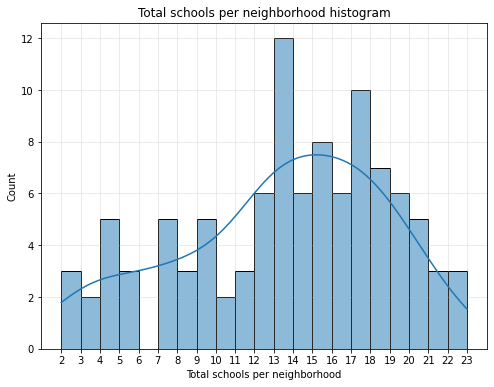

In [121]:
count, bin_edges = np.histogram(toronto_data['Total_schools_per_neigh'], 21)

plt.figure(figsize=(8,6))
plt.grid(True, alpha=0.3)
plt.xticks(bin_edges)
sns.histplot(data=toronto_data, x="Total_schools_per_neigh", kde=True, bins=21)
plt.xlabel('Total schools per neighborhood')
plt.title('Total schools per neighborhood histogram')
plt.show()

## Total parks and playgrounds per neighborhood histogram

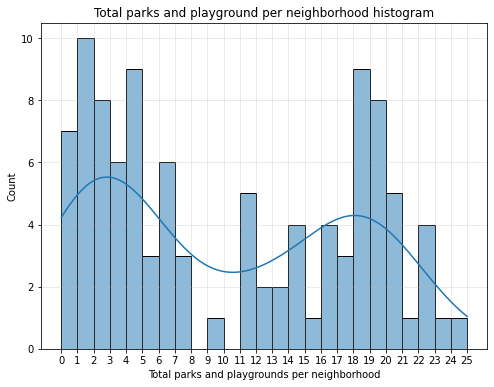

In [122]:
count, bin_edges = np.histogram(toronto_data['Total_parks/playground_per_neigh'], 25)

plt.figure(figsize=(8,6))
plt.grid(True, alpha=0.3)
plt.xticks(bin_edges)
sns.histplot(data=toronto_data, x="Total_parks/playground_per_neigh", kde=True, bins=25)
plt.xlabel('Total parks and playgrounds per neighborhood')
plt.title('Total parks and playground per neighborhood histogram')
plt.show()

## Total hospitals per neighborhood histogram

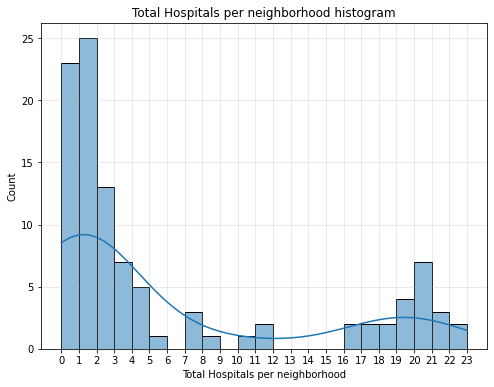

In [123]:
count, bin_edges = np.histogram(toronto_data['Total_hospitals_per_neigh'], 23)

plt.figure(figsize=(8,6))
plt.grid(True, alpha=0.3)
plt.xticks(bin_edges)
sns.histplot(data=toronto_data, x="Total_hospitals_per_neigh", kde=True, bins=23)
plt.xlabel('Total Hospitals per neighborhood')
plt.title('Total Hospitals per neighborhood histogram')
plt.show()

## Total grocery stores per neighborhood histogram

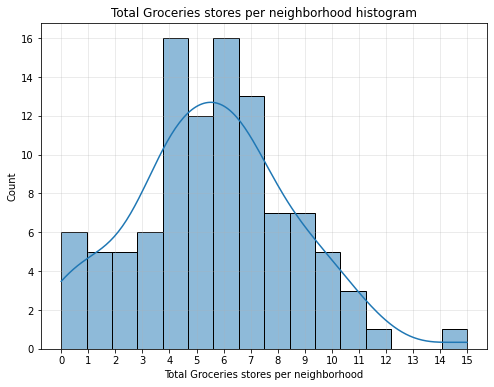

In [212]:
count, bin_edges = np.histogram(toronto_data['Total_groceries_per_neigh'], bins=16, range=(0, 16))

plt.figure(figsize=(8,6))
plt.grid(True, alpha=0.3)
plt.xticks(bin_edges)
sns.histplot(data=toronto_data, x="Total_groceries_per_neigh", kde=True, bins=16, common_norm=False)
plt.xlabel('Total Groceries stores per neighborhood')
plt.title('Total Groceries stores per neighborhood histogram')
plt.show()

In [148]:
# Skewness of distribution
toronto_data.skew(axis=0)

Total_schools_per_neigh            -0.473172
Total_parks/playground_per_neigh    0.209610
Total_hospitals_per_neigh           1.214953
Total_groceries_per_neigh           0.208327
dtype: float64

## Box plot

In [350]:
fig = go.Figure()
fig.add_trace(go.Box(y=toronto_data['Total_schools_per_neigh'], boxmean=True, name='Total_schools_per_neigh', text='kdhdsf'))
fig.add_trace(go.Box(y=toronto_data['Total_parks/playground_per_neigh'], boxmean=True, name='Total_parks/playground_per_neigh'))
fig.add_trace(go.Box(y=toronto_data['Total_hospitals_per_neigh'], boxmean=True, name='Total_hospitals_per_neigh'))
fig.add_trace(go.Box(y=toronto_data['Total_groceries_per_neigh'], boxmean=True, name='Total_groceries_per_neigh'))
fig.update_yaxes(nticks=25)
fig.update_layout(
    yaxis_title='Category amount per neigborhood', xaxis_title = 'Categories', showlegend=False, title_text="Toronto neighborhood boxplot"
)

fig.add_annotation(x=0.45, y=13.3,
            text="Mean = 13.3", showarrow=False)

fig.add_annotation(x=1.45, y=9.9,
            text="Mean = 9.9", showarrow=False)

fig.add_annotation(x=2.45, y=5.7,
            text="Mean = 5.7", showarrow=False)

fig.add_annotation(x=3.45, y=5.6,
            text="Mean = 5.6", showarrow=False)

fig.show()

In [259]:
toronto_data.describe()

,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,103.000000,103.000000,103.000000,103.000000
mean,13.320388,9.932039,5.669903,5.563107
std,5.297453,7.710779,7.543844,2.982531
min,2.000000,0.000000,0.000000,0.000000
25%,9.500000,3.000000,1.000000,4.000000
50%,14.000000,7.000000,2.000000,6.000000
75%,17.000000,18.000000,7.500000,7.000000
max,23.000000,25.000000,23.000000,15.000000


# K - means clustering

In [277]:
# k - mean clustering with different cluster amount and inertia value
kclusters = 1
inertia_disct = {}
toronto_grouped_clustering = toronto_data.drop('Neighborhood', 1)
for n in range(10):
# set number of clusters
    scaler = StandardScaler()
    toronto_grouped_clustering = scaler.fit_transform(toronto_grouped_clustering)

# run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    inertia_disct[kclusters] = kmeans.inertia_
    kclusters = kclusters + 1

inertia_disct

{1: 411.9999999999999,
 2: 249.1462738284966,
 3: 155.86910287242623,
 4: 122.66593466741794,
 5: 101.53860927466276,
 6: 87.9791129330497,
 7: 75.46941374564511,
 8: 63.31275545890907,
 9: 59.01546577798611,
 10: 52.87522944890183}

In [279]:
interia_df = pd.DataFrame.from_dict(inertia_disct, orient='index')

In [281]:
interia_df.columns = ['Interia_value']

In [282]:
interia_df

,Interia_value
1,412.000000
2,249.146274
3,155.869103
4,122.665935
5,101.538609
6,87.979113
7,75.469414
8,63.312755
9,59.015466
10,52.875229


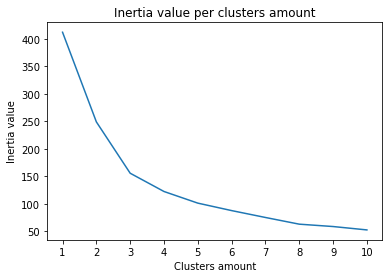

In [294]:
#  cluster amount and inertia value plot
plt.plot(interia_df.index, interia_df.Interia_value)
plt.xlabel('Clusters amount')
plt.ylabel('Inertia value')
plt.title('Inertia value per clusters amount')
plt.xticks(np.arange(1, 11, step=1))
plt.show()

### 5 clusters

In [73]:
toronto_data_5 = toronto_data.copy()

In [271]:
# set number of clusters
kclusters = 5
scaler = StandardScaler()
toronto_grouped_clustering_5 = toronto_data_5.drop('Neighborhood', 1)
toronto_grouped_clustering_5 = scaler.fit_transform(toronto_grouped_clustering_5)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_5)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 0, 1, 0, 4, 4, 4, 2, 0])

In [272]:
# Sum of squared distances of samples to their closest cluster center.
kmeans.inertia_

101.53860927466276

In [75]:
toronto_data_5.insert(0, 'Cluster Labels', kmeans.labels_)

In [76]:
df_cluster_5 = df.merge(toronto_data_5, how='left', on='Neighborhood')

In [77]:
df_cluster_5.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,20,4.0,2.0,4.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,4,16,6.0,1.0,7.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,10,16.0,16.0,5.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4,16,4.0,2.0,5.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,4,18.0,23.0,5.0


In [215]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [216]:
# create map for 5 Cluster
# SEE 2.JPEG
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster_5['Latitude'], df_cluster_5['Longitude'], df_cluster_5['Neighborhood'], df_cluster_5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [217]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,20,4.0,2.0,4.0
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,0,14,6.0,1.0,1.0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,14,2.0,0.0,1.0
7,M3B,North York,Don MillsNorth,43.745906,-79.352188,0,18,4.0,7.0,3.0
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,0,22,7.0,0.0,3.0
13,M3C,North York,Don MillsSouth,43.725900,-79.340923,0,12,6.0,0.0,1.0
17,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,0,16,4.0,0.0,2.0
18,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,13,0.0,2.0,1.0
27,M2H,North York,Hillcrest Village,43.803762,-79.363452,0,19,1.0,1.0,0.0
29,M4H,East York,Thorncliffe Park,43.705369,-79.349372,0,19,14.0,0.0,4.0


In [258]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 0].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000
mean,43.746208,-79.391929,0.0,17.409091,5.318182,1.681818,2.090909
std,0.053021,0.107763,0.0,3.080802,3.746571,2.417917,1.508992
min,43.643515,-79.577201,0.0,12.000000,0.000000,0.000000,0.000000
25%,43.726549,-79.487964,0.0,15.000000,2.250000,0.000000,1.000000
50%,43.755374,-79.369083,0.0,17.500000,4.000000,1.000000,2.000000
75%,43.785895,-79.332473,0.0,19.750000,7.000000,2.000000,3.750000
max,43.815252,-79.188711,0.0,23.000000,14.000000,8.000000,4.000000


In [218]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,10,16.0,16.0,5.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,4,18.0,23.0,5.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,4,18.0,21.0,6.0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,7,18.0,20.0,8.0
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,2,18.0,18.0,7.0
23,M4G,East York,Leaside,43.709060,-79.363452,1,17,14.0,17.0,4.0
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,5,19.0,21.0,5.0
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,4,19.0,21.0,6.0
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,1,3,18.0,17.0,6.0
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,1,4,18.0,20.0,7.0


In [257]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 1].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000
mean,43.666624,-79.382517,1.0,7.772727,17.545455,19.363636,6.272727
std,0.024828,0.011274,0.0,4.513808,2.364968,1.813848,1.695423
min,43.640816,-79.405678,1.0,2.000000,11.000000,16.000000,4.000000
25%,43.648965,-79.388790,1.0,4.000000,18.000000,18.250000,5.000000
50%,43.657557,-79.382016,1.0,7.000000,18.000000,20.000000,6.000000
75%,43.671524,-79.375946,1.0,12.000000,19.000000,20.000000,7.000000
max,43.728020,-79.360636,1.0,17.000000,21.000000,23.000000,10.000000


In [219]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,2,18,16.0,1.0,9.0
14,M4C,East York,Woodbine Heights,43.695344,-79.318389,2,20,22.0,1.0,12.0
16,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,2,17,17.0,1.0,9.0
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,21,14.0,1.0,9.0
21,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,2,17,12.0,1.0,10.0
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,18,25.0,4.0,9.0
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,18,20.0,2.0,15.0
35,M4J,East YorkEast Toronto,The Danforth East,43.685347,-79.338106,2,17,23.0,1.0,10.0
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,2,11,22.0,7.0,10.0
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,19,19.0,3.0,10.0


In [256]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 2].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000
mean,43.674678,-79.385708,2.0,16.428571,18.619048,2.476190,9.047619
std,0.022572,0.054678,0.0,3.171300,3.542262,1.661898,2.376472
min,43.628947,-79.464763,2.0,8.000000,12.000000,1.000000,5.000000
25%,43.661608,-79.428191,2.0,15.000000,16.000000,1.000000,7.000000
50%,43.676357,-79.400049,2.0,17.000000,19.000000,2.000000,9.000000
75%,43.689574,-79.338106,2.0,18.000000,22.000000,3.000000,10.000000
max,43.715383,-79.293031,2.0,21.000000,25.000000,7.000000,15.000000


In [220]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,3,10,1.0,1.0,0.0
22,M1G,Scarborough,Woburn,43.770992,-79.216917,3,11,0.0,4.0,3.0
26,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,8,0.0,11.0,6.0
50,M9L,North York,Humber Summit,43.756303,-79.565963,3,5,0.0,0.0,3.0
57,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,3,9,1.0,0.0,5.0
58,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,3,7,5.0,1.0,4.0
60,M3N,North York,DownsviewNorthwest,43.761631,-79.520999,3,12,1.0,1.0,4.0
65,M1P,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,3,9,0.0,11.0,5.0
76,M7R,MississaugaCanada Post Gateway Processing Centre,Enclave of L4W,43.636966,-79.615819,3,8,2.0,0.0,4.0
77,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,3,9,3.0,1.0,3.0


In [255]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 3].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,14.000000,14.000000,14.0,14.00000,14.000000,14.000000,14.000000
mean,43.730857,-79.419743,3.0,8.00000,1.357143,2.500000,3.357143
std,0.061322,0.176990,0.0,3.08844,1.446861,3.797773,1.736803
min,43.602414,-79.615819,3.0,2.00000,0.000000,0.000000,0.000000
25%,43.696180,-79.563154,3.0,7.25000,0.250000,0.000000,3.000000
50%,43.747860,-79.526621,3.0,9.00000,1.000000,1.000000,4.000000
75%,43.768652,-79.245819,3.0,9.75000,1.750000,2.750000,4.000000
max,43.836125,-79.160497,3.0,12.00000,5.000000,11.000000,6.000000


In [221]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
1,M4A,North York,Victoria Village,43.725882,-79.315572,4,16,6.0,1.0,7.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4,16,4.0,2.0,5.0
10,M6B,North York,Glencairn,43.709577,-79.445073,4,15,11.0,0.0,7.0
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,4,16,4.0,2.0,8.0
32,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,4,13,0.0,10.0,6.0
34,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,4,9,1.0,0.0,8.0
38,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,4,17,1.0,0.0,7.0
44,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,4,14,6.0,1.0,8.0
49,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,4,13,3.0,2.0,5.0
51,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,4,12,0.0,0.0,6.0


In [254]:
df_cluster_5[df_cluster_5['Cluster Labels'] == 4].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,24.000000,24.000000,24.0,24.000000,24.000000,24.000000,24.000000
mean,43.712170,-79.412194,4.0,15.041667,4.583333,1.416667,6.333333
std,0.046645,0.099655,0.0,2.911434,3.786896,2.145099,1.203859
min,43.605647,-79.532242,4.0,9.000000,0.000000,0.000000,4.000000
25%,43.695018,-79.487965,4.0,13.000000,2.000000,0.000000,5.750000
50%,43.715036,-79.443666,4.0,14.500000,4.000000,1.000000,6.500000
75%,43.746069,-79.310641,4.0,17.000000,6.000000,2.000000,7.000000
max,43.794200,-79.239476,4.0,22.000000,14.000000,10.000000,8.000000


### 4 Clusters

In [222]:
toronto_data_4 = toronto_data.copy()

In [273]:
# set number of clusters

scaler = StandardScaler()

kclusters = 4

toronto_grouped_clustering_4 = toronto_data_4.drop('Neighborhood', 1)
toronto_grouped_clustering_4 = scaler.fit_transform(toronto_grouped_clustering_4)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_4)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 0, 2, 2, 1, 3, 0])

In [274]:
kmeans.inertia_

122.66593466741794

In [224]:
toronto_data_4.insert(0, 'Cluster Labels', kmeans.labels_)

In [225]:
df_cluster_4 = df.merge(toronto_data_4, how='left', on='Neighborhood')

In [226]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [227]:
# create map for 4 Cluster
# SEE 2.JPEG
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster_4['Latitude'], df_cluster_4['Longitude'], df_cluster_4['Neighborhood'], df_cluster_4['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [228]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,0,14,6.0,1.0,1.0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,14,2.0,0.0,1.0
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0,10,1.0,1.0,0.0
13,M3C,North York,Don MillsSouth,43.725900,-79.340923,0,12,6.0,0.0,1.0
17,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,0,16,4.0,0.0,2.0
18,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,13,0.0,2.0,1.0
22,M1G,Scarborough,Woburn,43.770992,-79.216917,0,11,0.0,4.0,3.0
26,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,8,0.0,11.0,6.0
27,M2H,North York,Hillcrest Village,43.803762,-79.363452,0,19,1.0,1.0,0.0
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,0,18,7.0,8.0,1.0


In [260]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 0].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,29.000000,29.000000,29.0,29.000000,29.000000,29.000000,29.000000
mean,43.737909,-79.410591,0.0,11.793103,2.517241,2.103448,2.344828
std,0.056305,0.144661,0.0,4.585531,2.164992,3.143529,1.798330
min,43.602414,-79.615819,0.0,2.000000,0.000000,0.000000,0.000000
25%,43.706748,-79.532242,0.0,9.000000,1.000000,0.000000,1.000000
50%,43.756303,-79.408493,0.0,12.000000,2.000000,1.000000,2.000000
75%,43.773136,-79.273304,0.0,15.000000,4.000000,2.000000,4.000000
max,43.836125,-79.160497,0.0,20.000000,7.000000,11.000000,6.000000


In [229]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,10,16.0,16.0,5.0
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1,4,18.0,23.0,5.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,4,18.0,21.0,6.0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,7,18.0,20.0,8.0
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,2,18.0,18.0,7.0
23,M4G,East York,Leaside,43.709060,-79.363452,1,17,14.0,17.0,4.0
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,1,5,19.0,21.0,5.0
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,1,4,19.0,21.0,6.0
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,1,3,18.0,17.0,6.0
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,1,4,18.0,20.0,7.0


In [261]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 1].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000
mean,43.666624,-79.382517,1.0,7.772727,17.545455,19.363636,6.272727
std,0.024828,0.011274,0.0,4.513808,2.364968,1.813848,1.695423
min,43.640816,-79.405678,1.0,2.000000,11.000000,16.000000,4.000000
25%,43.648965,-79.388790,1.0,4.000000,18.000000,18.250000,5.000000
50%,43.657557,-79.382016,1.0,7.000000,18.000000,20.000000,6.000000
75%,43.671524,-79.375946,1.0,12.000000,19.000000,20.000000,7.000000
max,43.728020,-79.360636,1.0,17.000000,21.000000,23.000000,10.000000


In [230]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,2,18,16.0,1.0,9.0
14,M4C,East York,Woodbine Heights,43.695344,-79.318389,2,20,22.0,1.0,12.0
16,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,2,17,17.0,1.0,9.0
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,21,14.0,1.0,9.0
21,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,2,17,12.0,1.0,10.0
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2,18,25.0,4.0,9.0
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,18,20.0,2.0,15.0
35,M4J,East YorkEast Toronto,The Danforth East,43.685347,-79.338106,2,17,23.0,1.0,10.0
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,2,11,22.0,7.0,10.0
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,19,19.0,3.0,10.0


In [262]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 2].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000
mean,43.676360,-79.387128,2.0,16.227273,18.409091,2.500000,8.909091
std,0.023399,0.053774,0.0,3.235691,3.594428,1.625687,2.408499
min,43.628947,-79.464763,2.0,8.000000,12.000000,1.000000,5.000000
25%,43.661892,-79.426784,2.0,15.000000,16.000000,1.000000,7.000000
50%,43.677957,-79.402864,2.0,17.000000,19.000000,2.500000,9.000000
75%,43.692730,-79.338811,2.0,18.000000,21.500000,3.000000,10.000000
max,43.715383,-79.293031,2.0,21.000000,25.000000,7.000000,15.000000


In [231]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
0,M3A,North York,Parkwoods,43.753259,-79.329656,3,20,4.0,2.0,4.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,3,16,6.0,1.0,7.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,16,4.0,2.0,5.0
7,M3B,North York,Don MillsNorth,43.745906,-79.352188,3,18,4.0,7.0,3.0
10,M6B,North York,Glencairn,43.709577,-79.445073,3,15,11.0,0.0,7.0
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,3,22,7.0,0.0,3.0
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,3,16,4.0,2.0,8.0
29,M4H,East York,Thorncliffe Park,43.705369,-79.349372,3,19,14.0,0.0,4.0
32,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,3,13,0.0,10.0,6.0
34,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,3,9,1.0,0.0,8.0


In [263]:
df_cluster_4[df_cluster_4['Cluster Labels'] == 3].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000
mean,43.720987,-79.402247,3.0,16.733333,5.300000,1.400000,5.700000
std,0.051871,0.101766,0.0,3.453467,3.940506,2.206573,1.622046
min,43.605647,-79.554724,3.0,9.000000,0.000000,0.000000,3.000000
25%,43.698581,-79.487262,3.0,14.000000,2.250000,0.000000,4.000000
50%,43.722200,-79.442259,3.0,17.000000,4.000000,1.000000,6.000000
75%,43.752462,-79.307119,3.0,19.000000,6.750000,2.000000,7.000000
max,43.815252,-79.239476,3.0,23.000000,14.000000,10.000000,8.000000


### 6 clusters

In [232]:
toronto_data_6 = toronto_data.copy()

In [275]:
# set number of clusters
scaler = StandardScaler()

kclusters = 6

toronto_grouped_clustering_6 = toronto_data_6.drop('Neighborhood', 1)
toronto_grouped_clustering_6 = scaler.fit_transform(toronto_grouped_clustering_6)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_6)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 2, 5, 1, 1, 1, 3, 5])

In [276]:
kmeans.inertia_

87.9791129330497

In [234]:
toronto_data_6.insert(0, 'Cluster Labels', kmeans.labels_)

In [235]:
df_cluster_6 = df.merge(toronto_data_6, how='left', on='Neighborhood')

In [253]:
# create map for 6 Cluster
# SEE 2.JPEG
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_cluster_6['Latitude'], df_cluster_6['Longitude'], df_cluster_6['Neighborhood'], df_cluster_6['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [237]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,20,4.0,2.0,4.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,16,6.0,1.0,7.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,16,4.0,2.0,5.0
10,M6B,North York,Glencairn,43.709577,-79.445073,0,15,11.0,0.0,7.0
11,M9B,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,0,22,7.0,0.0,3.0
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,0,16,4.0,2.0,8.0
29,M4H,East York,Thorncliffe Park,43.705369,-79.349372,0,19,14.0,0.0,4.0
38,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,0,17,1.0,0.0,7.0
44,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,0,14,6.0,1.0,8.0
55,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,0,13,11.0,4.0,5.0


In [264]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 0].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000
mean,43.714442,-79.404484,0.0,17.727273,7.090909,1.136364,5.772727
std,0.056596,0.091572,0.0,3.042271,3.975030,1.125271,1.571527
min,43.605647,-79.554724,0.0,12.000000,1.000000,0.000000,3.000000
25%,43.677668,-79.482341,0.0,16.000000,4.000000,0.000000,4.000000
50%,43.715106,-79.431005,0.0,17.000000,6.000000,1.000000,6.000000
75%,43.752462,-79.316276,0.0,20.000000,11.000000,2.000000,7.000000
max,43.815252,-79.262029,0.0,23.000000,14.000000,4.000000,8.000000


In [238]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,10,16.0,16.0,5.0
23,M4G,East York,Leaside,43.709060,-79.363452,1,17,14.0,17.0,4.0
61,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,1,15,11.0,20.0,4.0
67,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,12,13.0,19.0,6.0
74,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,1,13,19.0,16.0,6.0
79,M4S,Central Toronto,Davisville,43.704324,-79.388790,1,12,15.0,20.0,5.0
91,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1,13,21.0,19.0,9.0
96,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,1,13,19.0,20.0,10.0


In [265]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 1].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,8.000000,8.000000,8.0,8.00000,8.000000,8.000000,8.000000
mean,43.691082,-79.380344,1.0,13.12500,16.000000,18.375000,6.125000
std,0.025893,0.015692,0.0,2.10017,3.422614,1.767767,2.232071
min,43.654260,-79.405678,1.0,10.00000,11.000000,16.000000,4.000000
25%,43.671524,-79.389142,1.0,12.00000,13.750000,16.750000,4.750000
50%,43.691943,-79.383160,1.0,13.00000,15.500000,19.000000,5.500000
75%,43.709983,-79.366619,1.0,13.50000,19.000000,20.000000,6.750000
max,43.728020,-79.360636,1.0,17.00000,21.000000,20.000000,10.000000


In [239]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,2,4,18.0,23.0,5.0
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,4,18.0,21.0,6.0
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,7,18.0,20.0,8.0
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,2,18.0,18.0,7.0
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,5,19.0,21.0,5.0
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2,4,19.0,21.0,6.0
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,2,3,18.0,17.0,6.0
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,2,4,18.0,20.0,7.0
48,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,2,4,18.0,19.0,6.0
80,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,2,7,19.0,22.0,5.0


In [266]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 2].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,14.000000,14.000000,14.0,14.000000,14.000000,14.000000,14.000000
mean,43.652648,-79.383760,2.0,4.714286,18.428571,19.928571,6.357143
std,0.007501,0.008255,0.0,1.683795,0.646206,1.639150,1.392681
min,43.640816,-79.400049,2.0,2.000000,18.000000,17.000000,4.000000
25%,43.647432,-79.386679,2.0,4.000000,18.000000,19.000000,5.250000
50%,43.651033,-79.382016,2.0,4.000000,18.000000,20.000000,6.000000
75%,43.657755,-79.379157,2.0,6.500000,19.000000,21.000000,7.000000
max,43.665860,-79.373306,2.0,7.000000,20.000000,23.000000,9.000000


In [240]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
22,M1G,Scarborough,Woburn,43.770992,-79.216917,3,11,0.0,4.0,3.0
26,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,8,0.0,11.0,6.0
32,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,3,13,0.0,10.0,6.0
34,M3J,North York,"Northwood Park, York University",43.767980,-79.487262,3,9,1.0,0.0,8.0
49,M6L,North York,"North Park, Maple Leaf Park, Upwood Park",43.713756,-79.490074,3,13,3.0,2.0,5.0
50,M9L,North York,Humber Summit,43.756303,-79.565963,3,5,0.0,0.0,3.0
51,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,3,12,0.0,0.0,6.0
57,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,3,9,1.0,0.0,5.0
58,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,3,7,5.0,1.0,4.0
59,M2N,North York,WillowdaleSouth,43.770120,-79.408493,3,14,3.0,2.0,4.0


In [267]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 3].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,22.000000,22.000000,22.0,22.000000,22.000000,22.000000,22.000000
mean,43.732297,-79.422418,3.0,9.818182,1.545455,2.227273,4.500000
std,0.051563,0.148340,0.0,3.527259,1.438494,3.611250,1.792843
min,43.602414,-79.615819,3.0,2.000000,0.000000,0.000000,0.000000
25%,43.706780,-79.540674,3.0,8.250000,0.250000,0.000000,4.000000
50%,43.742075,-79.488668,3.0,10.000000,1.000000,1.000000,4.000000
75%,43.766393,-79.262734,3.0,13.000000,2.750000,2.000000,5.750000
max,43.836125,-79.205636,3.0,14.000000,5.000000,11.000000,8.000000


In [241]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,4,18,16.0,1.0,9.0
14,M4C,East York,Woodbine Heights,43.695344,-79.318389,4,20,22.0,1.0,12.0
16,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,4,17,17.0,1.0,9.0
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,21,14.0,1.0,9.0
21,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,4,17,12.0,1.0,10.0
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,4,18,25.0,4.0,9.0
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,4,18,20.0,2.0,15.0
35,M4J,East YorkEast Toronto,The Danforth East,43.685347,-79.338106,4,17,23.0,1.0,10.0
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,4,11,22.0,7.0,10.0
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,4,19,19.0,3.0,10.0


In [268]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 4].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000
mean,43.674678,-79.385708,4.0,16.428571,18.619048,2.476190,9.047619
std,0.022572,0.054678,0.0,3.171300,3.542262,1.661898,2.376472
min,43.628947,-79.464763,4.0,8.000000,12.000000,1.000000,5.000000
25%,43.661608,-79.428191,4.0,15.000000,16.000000,1.000000,7.000000
50%,43.676357,-79.400049,4.0,17.000000,19.000000,2.000000,9.000000
75%,43.689574,-79.338106,4.0,18.000000,22.000000,3.000000,10.000000
max,43.715383,-79.293031,4.0,21.000000,25.000000,7.000000,15.000000


In [269]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,5,14,6.0,1.0,1.0
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,5,14,2.0,0.0,1.0
7,M3B,North York,Don MillsNorth,43.745906,-79.352188,5,18,4.0,7.0,3.0
12,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,5,10,1.0,1.0,0.0
13,M3C,North York,Don MillsSouth,43.725900,-79.340923,5,12,6.0,0.0,1.0
17,M9C,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,5,16,4.0,0.0,2.0
18,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,5,13,0.0,2.0,1.0
27,M2H,North York,Hillcrest Village,43.803762,-79.363452,5,19,1.0,1.0,0.0
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,5,18,7.0,8.0,1.0
39,M2K,North York,Bayview Village,43.786947,-79.385975,5,17,2.0,1.0,0.0


In [270]:
df_cluster_6[df_cluster_6['Cluster Labels'] == 5].describe()

,Latitude,Longitude,Cluster Labels,Total_schools_per_neigh,Total_parks/playground_per_neigh,Total_hospitals_per_neigh,Total_groceries_per_neigh
count,16.000000,16.000000,16.0,16.000000,16.000000,16.00000,16.000000
mean,43.744524,-79.387478,5.0,15.625000,3.500000,2.00000,1.187500
std,0.051295,0.125904,0.0,2.777889,2.221111,2.73252,1.046821
min,43.643515,-79.577201,5.0,10.000000,0.000000,0.00000,0.000000
25%,43.727847,-79.498509,5.0,14.000000,2.000000,0.00000,0.000000
50%,43.751698,-79.380345,5.0,15.500000,3.500000,1.00000,1.000000
75%,43.785138,-79.345148,5.0,18.000000,5.250000,2.00000,2.000000
max,43.806686,-79.160497,5.0,20.000000,7.000000,8.00000,3.000000
